## import what you need

In [61]:
import numpy as np
import math
from math import sqrt
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numba import jit
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import clear_output
from ipywidgets import FloatProgress
from IPython.display import display

In [62]:
from numpy import e as e

## Particle definition

In [63]:
class particle:
    m=1.6726219e-27 #mass (kg)
    rho=0 #density (kg/m^3)
    P=0 #pressure (Pa)
    x=0 #location (m)
    v=0 #speed (m/s)
    rho_0=0 #reference density (kg/m^3)
    K0=0 #reference adiabat 
    alpha=0 #smoothing width (m)
    aindex=5/3.

## Definition of our functions (leave as is)

In [64]:
def W(ri,alpha=1): 
    r=abs(ri/alpha)    
    y=0
    if (r<=1):
        y=21./2./np.pi*(1-r)**4*(1+4*r)
    return y/alpha**3

In [65]:
def dW(ri,alpha=1):
    r=abs(ri/alpha)
    y=0
    if (r<=1):
        y=210./np.pi*(r-1)**3*r
    return y/alpha**4

In [66]:
def compute_rho(particles):
    for i in range (len(particles)):
        particles[i].rho=0
        for j in range(len(particles)):
            r=particles[i].x-particles[j].x
            r=(r[0]**2+r[1]**2+r[2]**2)**.5
            particles[i].rho+=W(r,particles[j].alpha)*particles[j].m

In [67]:
def compute_pressure(particles):
    for i in range (len(particles)):
        particles[i].P=particles[i].K0*particles[i].rho**particles[i].aindex

In [68]:
def compute_gradient(particles):
    grad=np.zeros((len(particles),len(particles),3))
    for i in range (len(particles)):
        for j in range (len(particles)):
            r=particles[i].x-particles[j].x
            r_val=(r[0]**2+r[1]**2+r[2]**2)**.5
            if (r_val>0):
                r/=r_val
                grad[i,j]=dW(r_val,particles[j].alpha)*r
    return grad            

In [69]:
def time_advance(particles,grad,dt=1,x_adv=1):
    global G,nu
    for i in range (len(particles)):
        for j in range(len(particles)):
            val=(particles[j].m*(particles[i].P/particles[i].rho**2+particles[j].P/particles[j].rho**2))*grad[j,i]
            val+=G*particles[j].rho*(particles[j].x-particles[i].x)
            particles[i].v+=val*dt/2.
        particles[i].v-=nu*particles[i].v*dt/2.
    if (x_adv==1):
        for i in range (len(particles)):
            particles[i].x+=particles[i].v*dt

In [70]:
def recenter(particles):
    x_ave=np.zeros(3)
    m=0
    for i in range (len(particles)):
        x_ave+=particles[i].x
        m+=particles[i].m
    x_ave/=m
    for i in range (len(particles)):
        particles[i].x-=x_ave

In [71]:
def get_min_dt(particles):
    global length
    dt_min=1e10
    for i in range (len(particles)):
        vel=(particles[i].v[0]**2+particles[i].v[1]**2+particles[i].v[2]**2)**.5+1e-3
        dt=length/vel/100
        if (dt_min>dt):
            dt_min=dt
    return min(dt,.1)

In [72]:
def plot_3D(particles,plot_size=3,plot_axes=True,title=''):
    from mpl_toolkits.mplot3d import Axes3D
    n = len(particles)
    #coordinates
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    for i in range(n):
        data_x[i]=cp[i].x[0]
        data_y[i]=cp[i].x[1]
        data_z[i]=cp[i].x[2]
        data_m[i]=cp[i].m
    #generate figure and axes
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_x, data_y, data_z, c=data_m, linewidths=0,
               marker='o', s=8*plot_size, cmap=plt.cm.Wistia,alpha=.8) #s is the size of the plotted symbol 'o'
    #set autoscale parameters
    xc=(data_x.max()+data_x.min())/2.
    x_low=xc-(data_x.max()-data_x.min())/2.*1.1-1e-12
    x_high=xc+(data_x.max()-data_x.min())/2.*1.1+1e-12
    yc=(data_y.max()+data_y.min())/2.
    y_low=yc-(data_y.max()-data_y.min())/2.*1.1-1e-12
    y_high=yc+(data_y.max()-data_y.min())/2.*1.1+1e-12
    zc=(data_z.max()+data_z.min())/2.
    z_low=zc-(data_z.max()-data_z.min())/2.*1.1-1e-12
    z_high=zc+(data_z.max()-data_z.min())/2.*1.1+1e-12
    #set autoscale parameters
    ax.set_xlim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_ylim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_zlim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_box_aspect((1,1,1))
    if (plot_axes):#so we can switch the axis on or off
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_zlabel("z (m)")
        ax.grid(False) 
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
    else:
        ax.set_axis_off()
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    plt.suptitle(title)
    plt.show()


In [73]:
def weighthed_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    rm = r * m 
    wtd_r = np.sum(rm)/ np.sum(m)
    return wtd_r

def avg_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    r_mean, r_err = np.mean(r), np.std(r)
    return r_mean, r_err

In [74]:
def plot_2D(particles,t=0):
    global length
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(1,2,1)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    n=len(particles)
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    data_vx,data_vy, data_vz =np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        data_x[i]=particles[i].x[0]
        data_y[i]=particles[i].x[1]
        data_z[i]=particles[i].x[2]        
        data_m[i]=particles[i].m
        data_vx[i]=particles[i].v[0]
        data_vy[i]=particles[i].v[1]
        data_vz[i]=particles[i].v[2]

    ax.scatter(data_x,data_y,c=data_m, cmap=plt.cm.Wistia, s=40, alpha=0.75)
    ax.set_facecolor('black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_box_aspect(1)
    ax=fig.add_subplot(1,2,2)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    ax.scatter(data_x,data_z,c=data_m, cmap=plt.cm.Wistia, s=40, alpha=0.75)
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_box_aspect(1)
    ax.set_facecolor('black')
    plt.suptitle(str(t))
    clear_output(wait=True)
    show_inline_matplotlib_plots()
#     a = [data_x, data_y, data_z, data_m, data_vx,data_vy, data_vz ]  
    wtd_r = weighthed_radius(data_m, data_x, data_y, data_z)
    wtd_v = weighthed_radius(data_m, data_vx, data_vy, data_vz)
    a = [wtd_r, wtd_v]
    return a

In [75]:
def plot_2D_unwtd(particles,t=0):
    global length
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(1,2,1)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    n=len(particles)
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    data_vx,data_vy, data_vz =np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        data_x[i]=particles[i].x[0]
        data_y[i]=particles[i].x[1]
        data_z[i]=particles[i].x[2]        
        data_m[i]=particles[i].m
        data_vx[i]=particles[i].v[0]
        data_vy[i]=particles[i].v[1]
        data_vz[i]=particles[i].v[2]

    ax.scatter(data_x,data_y,c=data_m, cmap=plt.cm.Wistia, s=40, alpha=0.75)
    ax.set_facecolor('black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_box_aspect(1)
    ax=fig.add_subplot(1,2,2)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    ax.scatter(data_x,data_z,c=data_m, cmap=plt.cm.Wistia, s=40, alpha=0.75)
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_box_aspect(1)
    ax.set_facecolor('black')
    plt.suptitle(str(t))
    clear_output(wait=True)
    show_inline_matplotlib_plots()
#     a = [data_x, data_y, data_z, data_m, data_vx,data_vy, data_vz ]  
    avg_r, r_err = avg_radius(data_m, data_x, data_y, data_z)
    avg_v, v_err= avg_radius(data_m, data_vx, data_vy, data_vz)
    a = [avg_r, avg_v, r_err, v_err]
    return a

## Our initial conditions

In [76]:
ti=0
# tf=4
tf = 8
t=0
n_out=100
t_out=(tf-ti)/n_out
t_print=0
length=1e6
G=6.67408e-11
nu=1.5

# Define our particle types

In [77]:
domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 # density. Two rho0 means there are two layers
    if (i%5==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=3
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
print('planet mass '+str(M)+'kg')

planet mass 4.867374217961795e+24kg


In [78]:
# normalisation
M0 = 6e24
Mold = M
factor = M0/ Mold

domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 * factor # density. Two rho0 means there are two layers
    if (i%5==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=3
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
print('planet mass '+str(M)+'kg')

planet mass 6.000000000000007e+24kg


In [82]:
def plotting_fn(tlist, xlist_avg, mass,
                xlabel, ylabel, color, xlist_avg_err=None,
                param='', string = " ", ax=None, alpha=0.7):
    
    ax = ax or plt.gca()
    if xlist_avg_err is None:
        ax.plot(tlist, xlist_avg, color=color, alpha=alpha,
                label = r"{}={:0.2e}".format(param, string,))
    else:
        ax.errorbar(tlist, xlist_avg, xlist_avg_err,
                    color=color, alpha=alpha,
                    label = r"{}={:0.2e}".format(param, string))
        
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel,  fontsize = 14)
    ax.legend()

    
klist = [ i for i in [1,e, e**2, e**3, e**4] ] # what you want to vary
color = ["red", "blue", "green", "orange", "purple"]

# Plotting

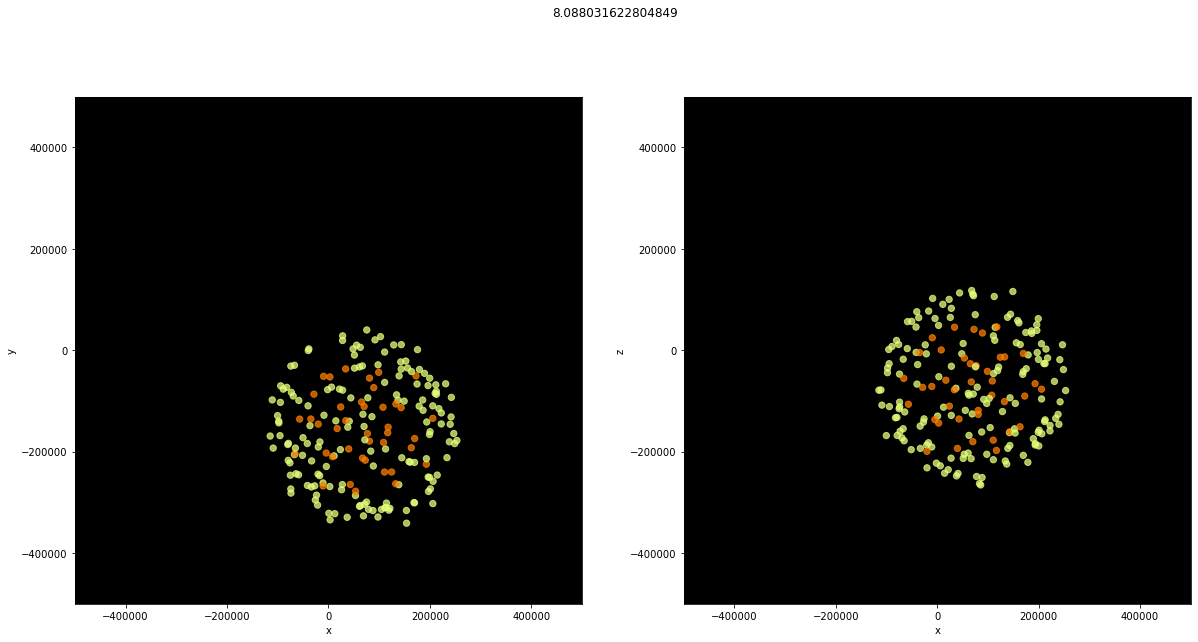

In [26]:
klist = [ i for i in [1,e, e**2, e**3, e**4] ]

mass_list = []
x, v, xavg, vavg, xavg_err, vavg_err = [], [], [], [], [], []
time = []

for k in klist:
    domain=np.array([-length,length,-length,length,-length,length])
    box=domain*.85
    cp=np.empty(0,dtype=object)
    N_total=100000
    Nc=200 # the number of particle clumps (also called particles herein)
    Np=max(int(N_total/Nc),1) # the number of particles per clump

    M=0
    
    for i in range (Nc):
        cp=np.append(cp,particle()) # we load the particles
        cp[i].K0= 10e4 # adiabatic reference 1 - 10
        cp[i].rho0=Np*8300 # density. Two rho0 means there are two layers
        if (i%5==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
            cp[i].rho0*= k
        cp[i].alpha=1e5 # changes shape of radial distribution
        cp[i].x=np.zeros(3)
        r=length*(0.5-np.random.random_sample()*.25)
        theta=np.pi*np.random.random_sample()
        phi=2*np.pi*np.random.random_sample()
        cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
        cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
        cp[i].x[2]=r*np.cos(theta)
        cp[i].v=np.zeros(3)
        cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
        M+=cp[i].m
    print('planet mass '+str(M)+'kg')
    
    mass_list.append("{:0.2e}".format(M))

#     from matplotlib import interactive
#     interactive(False)
    %matplotlib inline
    t=0
    dt=.1
    print(dt)
    twod_list, tlist = [], []
    twod_list_avg = []
    while (t<tf):
        print(dt)
        compute_rho(cp)
        compute_pressure(cp)
        grad=compute_gradient(cp)
        time_advance(cp,grad,dt=dt)
        compute_rho(cp)
        compute_pressure(cp)
        grad=compute_gradient(cp)
        time_advance(cp,grad,dt=dt,x_adv=0)
        dt=get_min_dt(cp)
        t+=dt
        t_print+=dt
        a = plot_2D(cp,t)
        b = plot_2D_unwtd(cp, t)
        twod_list.append(a)
        twod_list_avg.append(b)
        tlist.append(t)
 
    xlist = np.asarray( [twod_list[i][0] for i in range(len(twod_list))] )
    vlist = np.asarray( [twod_list[i][1] for i in range(len(twod_list))] )

    xlist_avg = np.asarray( [twod_list_avg[i][0] for i in range(len(twod_list_avg))] )
    vlist_avg  = np.asarray( [twod_list_avg[i][1] for i in range(len(twod_list_avg)) ] )
    xlist_avg_err = np.asarray( [twod_list_avg[i][2] for i in range(len(twod_list_avg))] )
    vlist_avg_err  = np.asarray( [twod_list_avg[i][3] for i in range(len(twod_list_avg))] )
    
    x.append(xlist)
    v.append(vlist)
    xavg.append(xlist_avg)
    vavg.append(vlist_avg)
    xavg_err.append(xlist_avg_err)
    vavg_err.append(vlist_avg_err)
    time.append(tlist)

In [27]:

# x.append(xlist)
# v.append(vlist)
# xavg.append(xlist_avg)
# vavg.append(vlist_avg)
# xavg_err.append(xlist_avg_err)
# vavg_err.append(vlist_avg_err)
# time.append(tlist)
mass_list = np.asarray(mass_list)

np.savez('changing_rho.npz', name1=x, name2=v,
        name3 = xavg, name4 = vavg,
        name5= xavg_err, name6= vavg_err,
        name7=time, name8=mass_list )

# data = np.load('changing_rho.npz', allow_pickle=True)
# print (data['name1'])

/Users/vashisth/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [84]:
data = np.load('changing_rho.npz', allow_pickle=True)

x = data['name1']
v = data['name2']
xavg = data['name3']
vavg = data['name4']

xavg_err = data['name5']
vavg_err = data['name6']
time = data['name7']
mass_list = data['name8']

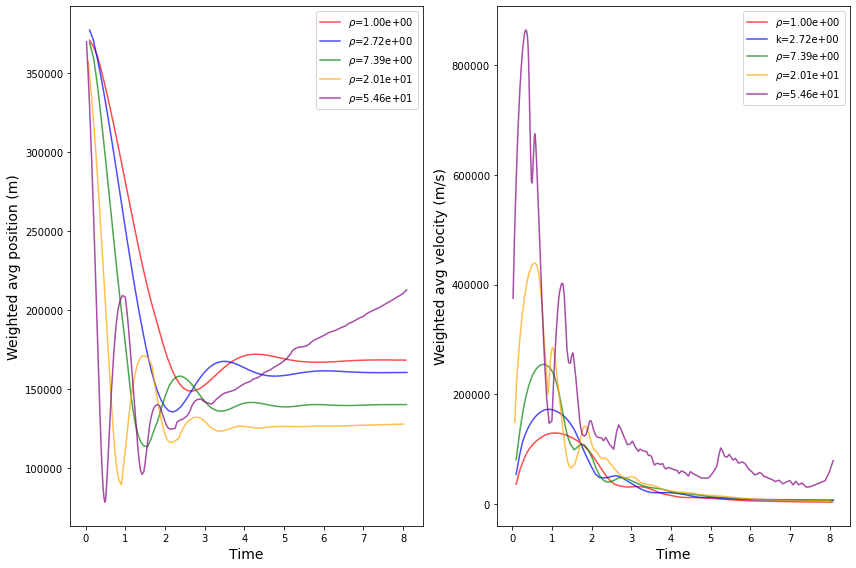

In [86]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=[12,8])


# weighted position
plotting_fn(tlist=time[0], xlist_avg=x[0], mass= mass_list[0],
                ylabel="Weighted avg position (m)", xlabel="Time", color= color[0], xlist_avg_err=None,
                param=r'$\rho$', string = klist[0], ax=ax0)

plotting_fn(tlist=time[1], xlist_avg=x[1], mass=mass_list[1],
                ylabel="Weighted avg position (m)", xlabel="Time", color= color[1], xlist_avg_err=None,
                param=r'$\rho$', string = klist[1], ax=ax0)

plotting_fn(tlist=time[2], xlist_avg=x[2], mass= mass_list[2],
                ylabel="Weighted avg position (m)", xlabel="Time", color= color[2], xlist_avg_err=None,
                param=r'$\rho$', string = klist[2], ax=ax0)

plotting_fn(tlist=time[3], xlist_avg=x[3], mass=mass_list[3],
                ylabel="Weighted avg position (m)", xlabel="Time", color= color[3], xlist_avg_err=None,
                param=r'$\rho$', string = klist[3], ax=ax0)


plotting_fn(tlist=time[4], xlist_avg=x[4], mass=mass_list[4],
                ylabel="Weighted avg position (m)", xlabel="Time", color= color[4], xlist_avg_err=None,
                param=r'$\rho$', string = klist[4], ax=ax0)


# weighted velocity
plotting_fn(tlist=time[0], xlist_avg=v[0], mass= mass_list[0],
                ylabel="Weighted avg velocity (m/s)", xlabel="Time", color= color[0], xlist_avg_err=None,
                param=r'$\rho$', string = klist[0], ax=ax1)

plotting_fn(tlist=time[1], xlist_avg=v[1], mass=mass_list[1],
                ylabel="Weighted avg velocity (m/s)", xlabel="Time", color= color[1], xlist_avg_err=None,
                param='k', string = klist[1], ax=ax1)

plotting_fn(tlist=time[2], xlist_avg=v[2], mass= mass_list[2],
                ylabel="Weighted avg velocity (m/s)", xlabel="Time", color= color[2], xlist_avg_err=None,
                param=r'$\rho$', string = klist[2], ax=ax1)

plotting_fn(tlist=time[3], xlist_avg=v[3], mass=mass_list[3],
                ylabel="Weighted avg velocity (m/s)", xlabel="Time", color= color[3], xlist_avg_err=None,
                param=r'$\rho$', string = klist[3], ax=ax1)

plotting_fn(tlist=time[4], xlist_avg=v[4], mass=mass_list[4],
                ylabel="Weighted avg velocity (m/s)", xlabel="Time", color= color[4], xlist_avg_err=None,
                param=r'$\rho$', string = klist[4], ax=ax1)

fig.tight_layout() 
plt.savefig('changing_rho.png', dpi=300)